In [1]:
# creating folder to save files 
import os
os.makedirs('Data/',exist_ok=True) 
# Confirm folder created
os.listdir("Data/")


[]

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
import numpy as np
from scipy import stats

In [3]:
filename="Data/insurance - insurance.csv"
df=pd.read_csv(filename)
df.head(5)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


# Question 1. Do smokers have higher insurance charges than non-smokers?

## Hypotheses

Null: Smokers and non-smokers have the same insurance charges.

Alternative: Smokers have higher insurance charges than non-smokers

*Numerical Data*

Comparing 2 groups a 2 sample T_test will be used



In [ ]:

# Filtering out those with and without super strength
non_smoker_df = df.loc[df['smoker']== 'no'].copy()
smoker_df = df.loc[df['smoker']== 'yes'].copy()

non_smoker = non_smoker_df['charges']
smoker = smoker_df['charges']

In [14]:
# test the strength group for normality
result_non_smoker = stats.normaltest(non_smoker)
result_non_smoker

NormaltestResult(statistic=316.4528082392722, pvalue=1.9193129759002216e-69)

In [15]:
result_smoker = stats.normaltest(smoker)
result_smoker

NormaltestResult(statistic=61.03941356533816, pvalue=5.564930630036463e-14)

In [19]:
np.shape(smoker)

(274,)

In [20]:
np.shape(non_smoker)

(1064,)

Data is not normal, but given that the 2 samples are greater than 15, the process will be continued.

In [22]:
# Test for equal variance
result = stats.levene(smoker, non_smoker)
result

LeveneResult(statistic=332.6135162726081, pvalue=1.5593284881803726e-66)

Variance is not the same for both samples, something to take into account

In [23]:
# Independent t-test with equal_var set to False
result = stats.ttest_ind(smoker, non_smoker, equal_var = False)
result

Ttest_indResult(statistic=32.751887766341824, pvalue=5.88946444671698e-103)

pvalue<alpha the null hypothesis can be rejected. There is a significant difference between the charges of non-smokers and smokers.
Analyzing the graph below smokers have higher charges that non-smokers.

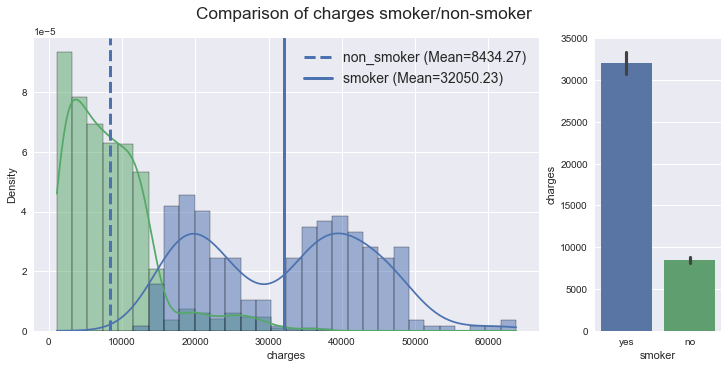

In [24]:
## Visualizing Sample means
fig, (ax,ax_bar) = plt.subplots(figsize= (10,5), ncols=2, 
                                constrained_layout=True,
                                gridspec_kw={'width_ratios':[0.8,0.2]})


# Histogram
ax = sns.histplot(data=df, x='charges',fill=True,hue='smoker',kde=True,
                  stat='density',common_norm=False,ax=ax)

ax.axvline(np.mean(non_smoker), ls='--',lw=3, 
           label=f"non_smoker (Mean={np.mean(non_smoker):.2f})")

ax.axvline(np.mean(smoker), ls='-', lw=3, 
           label=f"smoker (Mean={np.mean(smoker):.2f})")

ax.legend(prop={"size":14}, loc='upper right')#bbox_to_anchor=[1,1])
## Barplot
sns.barplot(data=df, x='smoker',y='charges',ax = ax_bar)
fig.suptitle('Comparison of charges smoker/non-smoker',fontsize='xx-large');

# Question 2. Are men more likely to smoke than women?

## Hypotheses

Null: Men and women are equal likely to smoke.

Alternative: Men are more likely to smoke than women

*Categorical Data*

chi-Square Test







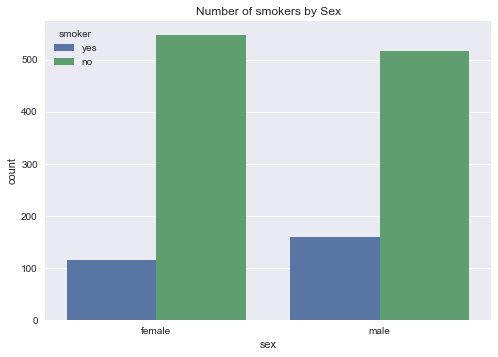

In [26]:
ax = sns.countplot(data=df, x='sex',hue='smoker',)
ax.set_title("Number of smokers by Sex");

In [27]:
# calculate the contingency table with pd.cross-tab
table = pd.crosstab(df['sex'], df['smoker'])
table

smoker,no,yes
sex,,
female,547,115
male,517,159


In [28]:
result = stats.chi2_contingency(table)
chi2, p, deg_free, expected_vals = result #this labels the results

In [29]:
# What was our p-value?
print(p)
p<.05

0.006548143503580696


True

The alternate hypothesis is accepted. Men are more likely to smoke than women.

# Question 3. Do different regions have different charges, on average?

## Hypotheses

Null: Different regions have the same charges.

Alternative: Different regions have different results

*Numerical Data*

Comparing more than 2 groups a Anova test will be used


In [54]:
groups = {}
## Loop through all unique categories
for i in df['region'].unique():
    ## Get series for group and rename
    data = df.loc[df['region']==i,'charges'].copy()
    
    # save into the dictionary
    groups[i] = data
groups.keys()

dict_keys(['southwest', 'southeast', 'northwest', 'northeast'])

In [55]:
# Check for outliers in weight for strength group

for region,charges in groups.items():
    outliers=np.abs(stats.zscore(charges))>3
    charges=charges.loc[~outliers]
    groups[region]=charges

In [57]:
## Running normal test on each group and confirming there are >20 in each group
norm_results = {}
for i, data in groups.items():
    stat, p = stats.normaltest(data)
    ## save the p val, test statistic, and the size of the group
    norm_results[i] = {'n': len(data),
                             'p':p,
                             'test stat':stat,}
## convert to a dataframe
norm_results_df = pd.DataFrame(norm_results).T
### checking sig with pandas 
norm_results_df['sig'] = norm_results_df['p'] < .05 
norm_results_df

,n,p,test stat,sig
southwest,317.0,7.728611e-22,97.223886,True
southeast,362.0,1.936990e-13,58.544942,True
northwest,318.0,2.940543e-19,85.341045,True
northeast,320.0,3.557877e-17,75.749565,True


The groups does not have a normal distribution, but given that every group has over 15 observations, the test can be done.

In [60]:
stats.levene(*groups.values())

LeveneResult(statistic=9.518349004554441, pvalue=3.2035503711783993e-06)

The assumption of the equal variance is not met. A non-parametric test is needed.

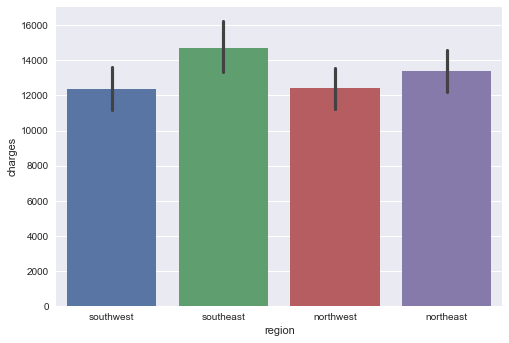

In [59]:
sns.barplot(data=df,x='region',y='charges');

The Kruskal-Wallis test is select to test the hypothesis for non-parametric.

In [64]:
stats.kruskal(*groups.values())

KruskalResult(statistic=6.914045702545643, pvalue=0.07468847911322242)

pvalue is greater that the alpha that means that the null hypothesis is met, there is no signifficant difference between the different regions.